In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sklm
import math
import scipy.stats as ss
import statsmodels.api as sm
import warnings


from pandas_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import beta
from sklearn.neighbors.kde import KernelDensity
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import linear_model

scaler = MinMaxScaler()

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

C:\Users\daniele\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\daniele\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Excercise 1-a) 
# Introduction

To perform this test, the dataset found at the following [link](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) was retrieved. The purpose of the analysis is to predict the hourly traffic volume on Interstate 94 in the United States, which connects Minneapolis and St Paul. More information about the dataset can be found at the previoused page linked.

# 0.0 Data Retrival

Retrieve data to begin analysis

In [2]:
df = pd.read_csv('0.0_datasets/Metro_Interstate_Traffic_Volume.csv',sep=';')

# 1.0 Data Understanding

Following the steps of the CRISP-DM methodology, we begin the analysis by performing an initial and cursory exploration of the dataset.

## 1.1 How is the dataset composed?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


## 1.2 Exploratory report

In [4]:
profile = ProfileReport(df, title='Dataset Report', explorative=True)
profile.to_notebook_iframe()

As the report above shows, the dataset has the following main characteristics:
- there are columns with quantitative and qualitative values --> mixed dataset
- the columns are all valorized --> no missing data
- the numerical columns present a strong asymmetry
- the correlation between the numerical variables is not significant 

# 2.0 Data Preparation

In [5]:
df.sample(2)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
30599,None,262.74,0.00,0.0,1,Clear,sky is clear,30/01/2017 03:00,312
13956,None,280.51,0.25,0.0,90,Rain,light rain,27/04/2014 01:00,770


In this step it is necessary to operate the correct encoding operations and transformations to prepare the dataset for the next modeling phase.

# 2.1 Columns preparation

## 2.1.1 date_time column

The temporal information was decided to be translated to reflect a possible underlying structure. According to this logic therefore it was decided to:
- translate each day according to the day number of the corresponding week (for example: May 5 = Monday)
- retrive each number of week, from 1 to 52

In [6]:
df['hour'] = df['date_time'].apply(lambda x: x[11:17])
df['date'] = df['date_time'].apply(lambda x: x[0:10])
df = df.drop(columns=['date_time'])

In [7]:
df['date'] = pd.to_datetime(df['date'])
df['hour'] = pd.to_datetime(df['hour'], format="%H:%M").dt.time

In [8]:
df['date_cat'] = df.date.dt.dayofweek
df['month_cat'] = df.date.dt.month
df['year_cat'] = df.date.dt.year
df['week_cat'] = df.date.dt.isocalendar().week
df = df.drop(columns=['date'])

## 2.1.2 Encoding categorical columns

At this point it's possible to make the encoding of all the new (and old) categorical features. The following columns it's been decide to make a label encoder:

In [9]:
df['weather_main_enc'] = LabelEncoder().fit_transform(df['weather_main'])
df['holiday_enc'] = LabelEncoder().fit_transform(df['holiday'])
df['hour_enc'] = LabelEncoder().fit_transform(df['hour'])

For the following column, said that it presents a greater number of categories, it's been decided to make a frequency encoding, in order to (possibly) use it in a proper way in the modelling phase.

In [10]:
fq = df.groupby('weather_description').size()/len(df)    
df.loc[:, "{}_enc".format('weather_description')] = df['weather_description'].map(fq)   

## 2.1.3 temperature column

Translate from Kelvin to Celsius for better interpretability.

In [11]:
df['temp_c'] = df['temp'].apply(lambda x: x-273.15 if x > 0 else 0)
df = df.drop(columns=['temp'])

## 2.2 Dataset enrichment

During this phase of preliminary analysis I thought that, given the information present in some columns (the "holiday" column above all) could be useful an enrichment operation, in order to expand the original dataset. By the following Wikipedia link, it's been retrieval the table regarding US holidays, in terms of expenses (in USD billions dollars) and "importance", represent by the share of population celebrating each holiday reported.

In [12]:
url = "https://en.wikipedia.org/wiki/Public_holidays_in_the_United_States"
table = pd.read_html(url, header=0)[2]
table = table[['Holiday','Date','% of Americans celebrating',"USD sales (in billions)[11]"]]
table.head(2)

,Holiday,Date,% of Americans celebrating,USD sales (in billions)[11]
0,Christmas,December 25 (Fixed),92–96%[12][13][14][15],$630.5
1,Thanksgiving,November 22–28 (Floating Thursday),87–90%[16][17],(part of Christmas sales)


Given the information reported in the above table, it's been created new columns to the original dataset: in this POC the creation has been pursued manually-based.

### 2.2.1 New column #1: Holiday importance

In [13]:
df['holiday_importance'] = 0
df['holiday_importance'] = df['holiday_importance'].mask(df['week_cat'] == 47, 0.87) # thanksgiving
df['holiday_importance'] = df['holiday_importance'].mask((df['week_cat'] >= 12) & (df['week_cat'] <= 15), 0.80) # easter, spring break
df['holiday_importance'] = df['holiday_importance'].mask((df['week_cat'] >= 18) & (df['week_cat'] <= 19), 0.84) # mother's day
df['holiday_importance'] = df['holiday_importance'].mask((df['week_cat'] == 26), 0.78) # indipendence day
df['holiday_importance'] = df['holiday_importance'].mask((df['week_cat'] == 24), 0.75) # father's day
df['holiday_importance'] = df['holiday_importance'].mask((df['week_cat'] == 43), 0.65) # halloween
df['holiday_importance'] = df['holiday_importance'].mask((df['week_cat'] == 6), 0.55) # valentine's day
df['holiday_importance'] = df['holiday_importance'].mask((df['week_cat'] == 11), 0.51) # saint patrick's day
df['holiday_importance'] = df['holiday_importance'].mask((df['week_cat'] >= 51), 0.95) # christmas
df['holiday_importance'] = df['holiday_importance'].mask((df['week_cat'] == 52), 0.40) # new year's eve

### 2.2.2 New column #2: Holiday expenses

In [14]:
df['holiday_expenses'] = 0
df['holiday_expenses'] = df['holiday_expenses'].mask(df['week_cat'] == 47, 630) # thanksgiving
df['holiday_expenses'] = df['holiday_expenses'].mask((df['week_cat'] >= 12) & (df['week_cat'] <= 15), 16) # easter, spring break
df['holiday_expenses'] = df['holiday_expenses'].mask((df['week_cat'] >= 18) & (df['week_cat'] <= 19), 19) # mother's day
df['holiday_expenses'] = df['holiday_expenses'].mask((df['week_cat'] == 26), 68) # indipendence day
df['holiday_expenses'] = df['holiday_expenses'].mask((df['week_cat'] == 24), 12.7) # father's day
df['holiday_expenses'] = df['holiday_expenses'].mask((df['week_cat'] == 43), 6.9) # halloween
df['holiday_expenses'] = df['holiday_expenses'].mask((df['week_cat'] == 6), 18.9) # valentine's day
df['holiday_expenses'] = df['holiday_expenses'].mask((df['week_cat'] == 11), 4.4) # saint patrick's day
df['holiday_expenses'] = df['holiday_expenses'].mask((df['week_cat'] >= 51), 630) # christmas
df['holiday_expenses'] = df['holiday_expenses'].mask((df['week_cat'] == 52), 630) # new year's eve

In [15]:
df = df.drop(columns=['holiday','weather_main','weather_description','hour'])

In [16]:
df.head(3)

,rain_1h,snow_1h,clouds_all,traffic_volume,date_cat,month_cat,year_cat,week_cat,weather_main_enc,holiday_enc,hour_enc,weather_description_enc,temp_c,holiday_importance,holiday_expenses
0,0.0,0.0,40,5545,4,2,2012,6,1,7,9,0.071799,15.13,0.55,18.9
1,0.0,0.0,75,4516,4,2,2012,6,1,7,10,0.096797,16.21,0.55,18.9
2,0.0,0.0,90,4767,4,2,2012,6,1,7,11,0.105406,16.43,0.55,18.9


# 2.3 Columns rescaling

Given the strong asymmetry present in some columns, it was decided to try to correct it by a transformation capable of making each variable "wider" in order to possibly increase its discriminative power. The trasformation implies the scaling in the [0,1] range.

The following transformations have been tried: logarithmic, fit of a kernel and fit of an inverse beta. This last one has brought the best results and is the one implemented below.

In [17]:
for i in df:
    if ('cat' in i) | ('enc' in i):
        df[i] = df[i].astype('object')

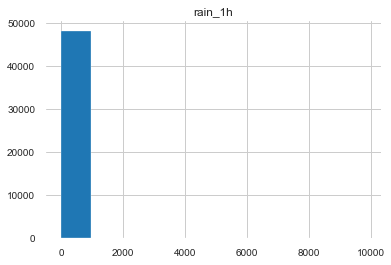

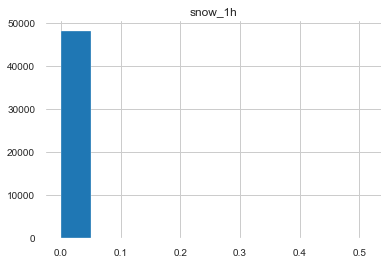

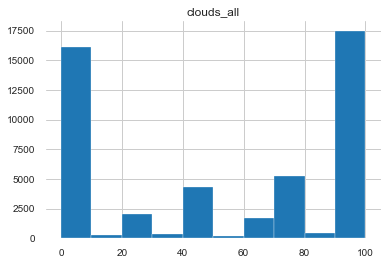

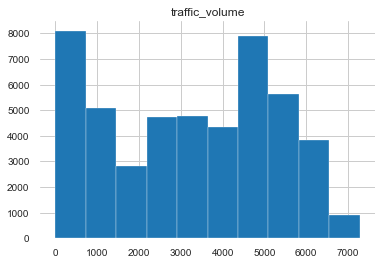

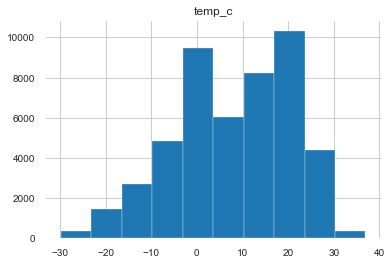

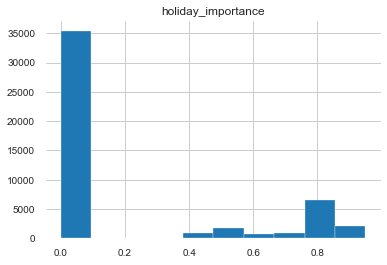

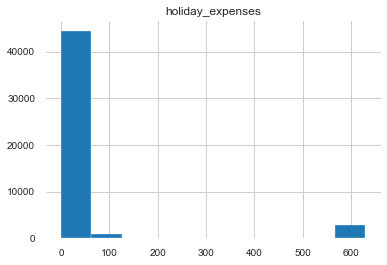

In [18]:
for i in df:
    if df[i].dtype != 'object':
        plt.figure(i)
        plt.title(i)
        df[i].hist()

In [19]:
for col in df:
    if (df[col].dtype == 'object') | ('traffic' in col):
        pass
    else:
        a,b,floc,scale = beta.fit(df[col])
        t0 = beta.rvs(a, b, size=len(df[col]))
        df["{}_beta".format(col)] = (t0-t0.min())/(t0.max()-t0.min())

The following is the final dataset

In [20]:
df = df[['rain_1h_beta', 'snow_1h_beta',
       'clouds_all_beta', 'temp_c_beta', 'holiday_importance_beta',
       'holiday_expenses_beta','weather_main_enc', 'holiday_enc',
       'weather_description_enc','week_cat','year_cat','month_cat','date_cat','hour_enc','traffic_volume']]

# 3.0 Modelling

Given the nature of the dataset and the instructions for the analysis, it was decided to use as a supervised algorithm the one offered by the Catboost library, capable of automatically processing categorical variables.

## 3.1 Modelling preparation

Before proceding to the fit of the model, it's necessary to explicit the type of categorical columns as string.

In [21]:
for i in df:
    if df[i].dtype == 'object':
        df[i] = df[i].astype(str)

## 3.2 Train, validation, test set creation

In [22]:
train, validate, test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])

In [23]:
x_train = train.drop(columns=['traffic_volume'])
y_train = train[['traffic_volume']]

x_val = validate.drop(columns=['traffic_volume'])
y_val = validate[['traffic_volume']]

x_test = test.drop(columns=['traffic_volume'])
y_test = test[['traffic_volume']]

## 3.3 Fit-Predict

In [24]:
categorical_features_indices = np.where(x_train.dtypes != np.float)[0]

In [25]:
model = CatBoostRegressor(iterations=500, verbose=100)
model.fit(x_train, y_train,cat_features=categorical_features_indices,eval_set=(x_val, y_val),plot=False)
y_val_pred = model.predict(x_val)
y_pred = model.predict(x_test)

Learning rate set to 0.141519
0:	learn: 1779.6383698	test: 1791.7798092	best: 1791.7798092 (0)	total: 197ms	remaining: 1m 38s
100:	learn: 772.5048117	test: 728.6805402	best: 728.6805402 (100)	total: 3.95s	remaining: 15.6s
200:	learn: 713.6715822	test: 664.2919354	best: 664.2919354 (200)	total: 8.45s	remaining: 12.6s
300:	learn: 683.8207695	test: 640.9015735	best: 640.9015735 (300)	total: 13.2s	remaining: 8.75s
400:	learn: 660.1431553	test: 623.5872126	best: 623.5872126 (400)	total: 18s	remaining: 4.44s
499:	learn: 642.3703708	test: 612.6211538	best: 612.5820696 (498)	total: 23.5s	remaining: 0us

bestTest = 612.5820696
bestIteration = 498

Shrink model to first 499 iterations.


**Note**:This is a "baseline" model. It has been tried also a fine tuning of the parameters through grid search and relative cross-validation that have carried in a first turn to results in line with the baseline model. However, not having had the time to deepen some parameters, I preferred to keep the model in its simplest version here reported.

# 4.0 Evaluation

For the evaluation phase i choose to print different metrics and graphs.

In [26]:
def print_metrics(y_true, y_predicted, n_parameters, y_val, y_val_pred):
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_val = sklm.r2_score(y_val, y_val_pred)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2 on validation      = ' + str(r2_val))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))

In [27]:
def hist_resids(y_test, y_score):
    resids = np.subtract(y_test, y_score)
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')

In [28]:
def resid_qq(y_test, y_score):
    resids = np.subtract(y_test, y_score)
    ss.probplot(resids, plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')

In [29]:
def resid_plot(y_test, y_score):
    resids = np.subtract(y_test, y_score)
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')

## 4.1 Metrics

In [30]:
print_metrics(y_test, y_pred, df.shape[1]-1, y_val, y_val_pred)  

Mean Square Error      = 357202.50794216705
Root Mean Square Error = 597.6642100227912
Mean Absolute Error    = 405.11852929942825
Median Absolute Error  = 277.0691548343784
R^2 on validation      = 0.9056951297565158
R^2                    = 0.9110277837525785
Adjusted R^2           = 0.9107871682312104


Short comment:
- The MAE and median absolute error are quite close together given the type of problem, indicating a quite good model fit despite a few significant outliers in the residuals. 
- The R2, R2 adjusted and the R2 on the validation set are both fairly close to one, indicating that the model is making useful predictions, without overfitting.

## 4.2 Residual

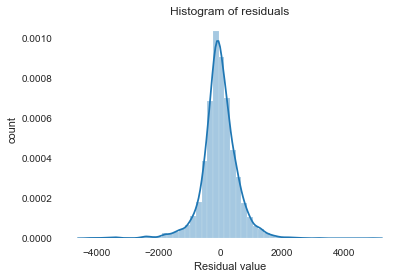

In [31]:
hist_resids(y_test.traffic_volume, y_pred)

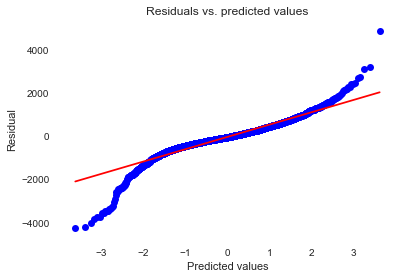

In [32]:
resid_qq(y_test.traffic_volume, y_pred)

In order to evaluate the quality of the predictions, it's also useful to analyze the residual plot derived from the prediction: if the residuals are close to a normal distribution the quality of the prediction should be seen as good. What has to be said after the previous two graph?
- the histrogram of residual is quite promising, but it's possible to see some fat tails, expecially on the left side of the distribution
- the qq-plot confirm the "fat-tails" problems arise frm the histrogram: this is an indicator that for a few sample the predictions are not so good, there is a bit of skewness expecially for large residuals.

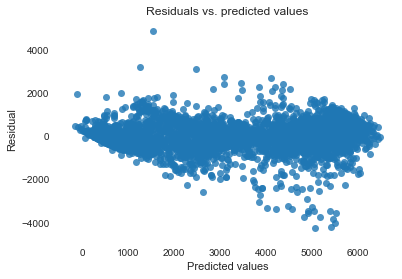

In [33]:
resid_plot(y_test.traffic_volume, y_pred) 

The graph above is quite informative: it tells us that the most of the reisduals are very close to the "0 values", as emerges from the previous histogram, but while predicted values are growing apppear some dispersion, expecially for large values. This tell us that the model seems to do a good job in predictiing traffic volumns for low values, but when traffic grows, the model is not so good in identified it. It's necessary to make some fine tuning to the model in order to catch also this "missing" behavior.

## 4.3 Features importance

In [34]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,hour_enc,43.516089
1,date_cat,23.551679
2,week_cat,6.793205
3,year_cat,5.635718
4,weather_main_enc,4.577817
5,holiday_enc,4.043067
6,month_cat,3.940480
7,weather_description_enc,1.694364
8,holiday_expenses_beta,1.483972
9,rain_1h_beta,1.249465


From this analysis emerges that the most important features useful for predicting traffic volumes are the "time features" and this, in my opinion, make some sense.
- The most important feature is the hour of the day: based on time of the day the model can build a fairly good prediction of the traffic.
- Also the other features in the "top 5" reflect this behaviour: the day of the week is the second best predictor, following by the week of the year
- In 5th position appears the only feature related to the weather.
- It's interesitng to notice that the numeric features, even after the scaling process, seems quite unuseful for predicting the traffic volumes: this maybe should be deeply investigated for catching better the variance missed as we have previously seen in the residual plots.

# Elasticty Test

In [34]:
el = df.select_dtypes(exclude='object')

In [35]:
x_test = x_test[el.drop(columns='traffic_volume').columns]

<Figure size 432x288 with 0 Axes>

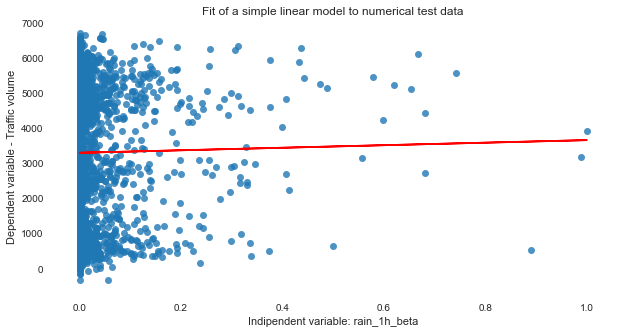

<Figure size 432x288 with 0 Axes>

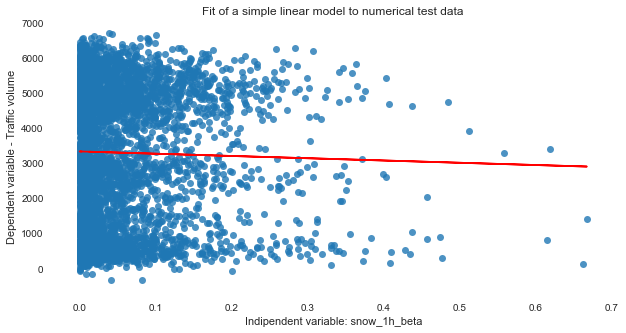

<Figure size 432x288 with 0 Axes>

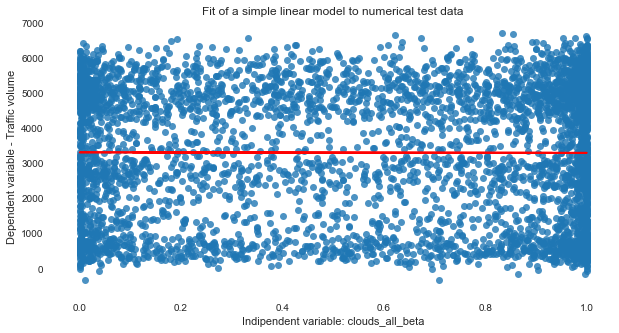

<Figure size 432x288 with 0 Axes>

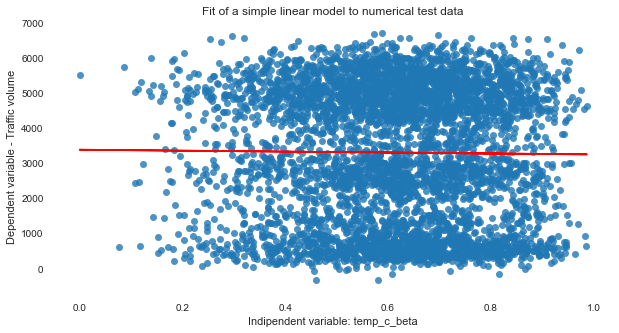

<Figure size 432x288 with 0 Axes>

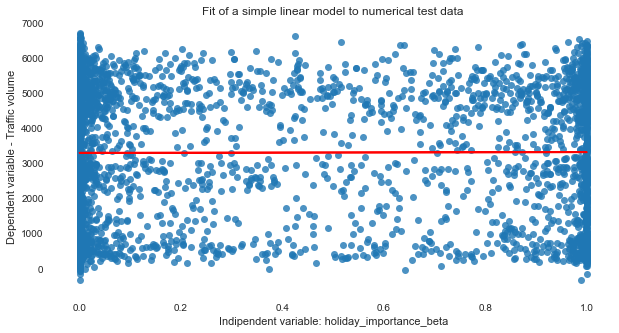

<Figure size 432x288 with 0 Axes>

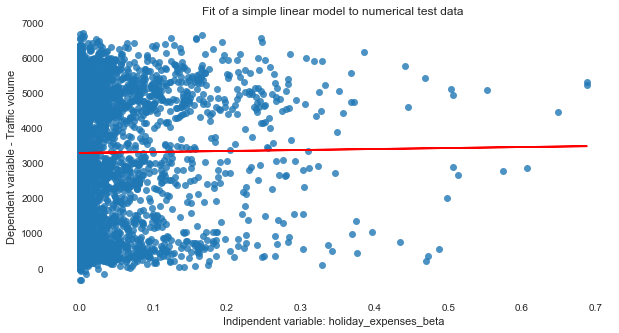

In [36]:
for i in x_test:
    lin_mod = linear_model.LinearRegression()
    lin_mod.fit(x_test[i].values.reshape(-1,1), y_pred)
    y_score = lin_mod.predict(x_test[i].values.reshape(-1,1))
    plt.figure(i)
    plt.figure(figsize=(10,5))
    plt.title('Fit of a simple linear model to numerical test data')
    sns.regplot(x_test[i],y_pred,fit_reg=False)
    plt.plot(x_test[i],y_score, c='red')
    plt.xlabel('Indipendent variable: '+ i)
    plt.ylabel('Dependent variable - Traffic volume')

In this step i try to see the relationship with the numerical variables in the dataset and a simle linear regression fitted on the test data. As can be seen, the dependent variable is not touched by variations in this indipendent variables, as can be seen in the feature importances phase where numeric features have the lowest importance.

In [37]:
def plot_box(df, col, col_y = 'traffic_volume'):
    sns.set_style("whitegrid")
    sns.boxplot(col, col_y, data=df)
    plt.xlabel(col)
    plt.ylabel(col_y)
    plt.show()

In [38]:
cat = df.select_dtypes(exclude='float64')

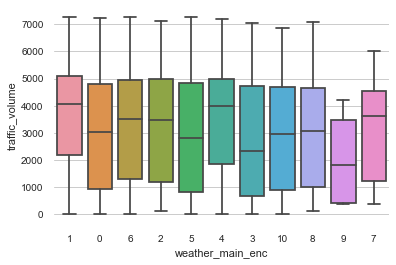

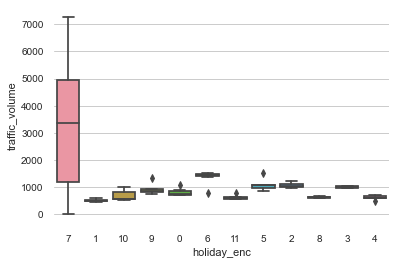

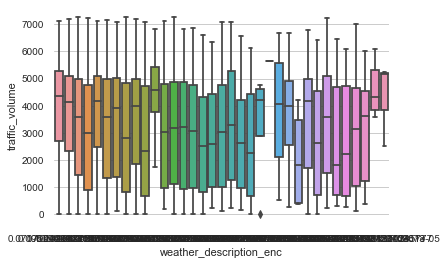

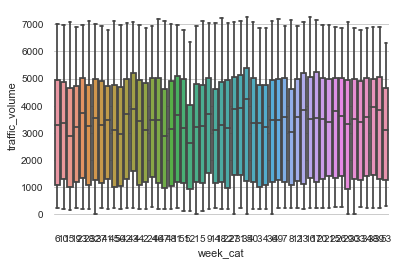

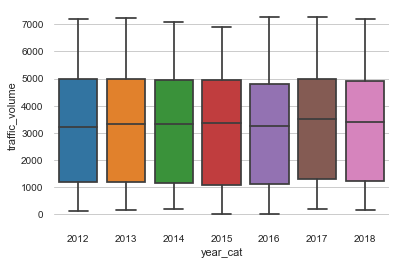

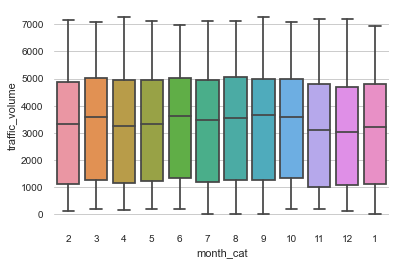

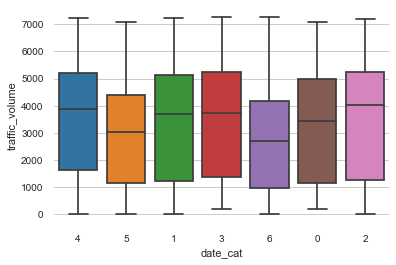

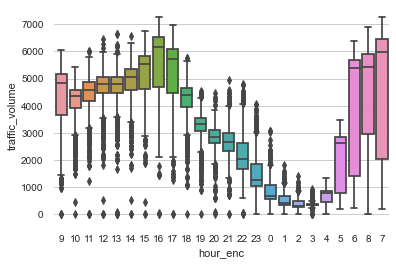

In [39]:
for i in cat:
    if i == 'traffic_volume':
        pass
    else:
        plt.figure(i)
        plot_box(df,i)   

Even if it was not requested, i plot the boxplot of the categorical variables vs the indipendent variable. The most interesting result is clearly from the relationship with the hour: the traffic volumes slow down during the evening while increase in the morning and in the late afternoon. Similar result is finding for the day of the week: during day 5 and 6 (saturday and sunday), traffic volumes decreases. 

----------------------------------------